# Neo4j GraphRAG Retriever Notebook

This notebook demonstrates how to use various retrievers and Cypher patterns with Neo4j GraphRAG for asset manager and cybersecurity risk retrieval.


In [ ]:
%pip install -r requirements.txt

In [ ]:
import os
from neo4j import GraphDatabase
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings
from neo4j_graphrag.retrievers import VectorRetriever, VectorCypherRetriever, Text2CypherRetriever
from neo4j_graphrag.generation import GraphRAG
from neo4j_graphrag.schema import get_schema
from dotenv import load_dotenv
import pandas as pd
from IPython.display import display, HTML
import textwrap

from IPython.core.display import HTML
display(HTML("<style>.output_area pre {white-space: pre-wrap; word-break: break-word;}</style>"))

# Load environment variables
load_dotenv()
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USER = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))


## Initialize LLM and Embedder

This section sets up the Large Language Model (LLM) and the embedding model for use in retrieval-augmented generation (RAG) workflows.

- **LLM**: Uses OpenAI's GPT-4o model via the `OpenAILLM` interface.
- **Embedder**: Uses OpenAI's embedding API via the `OpenAIEmbeddings` class.

> **Note:**  
> - The `OPENAI_API_KEY` must be set in your environment variables or [.env](cci:7://file:///c:/Users/Alison%20Cossette/OneDrive/GitHub/graphrag-ebook/.env:0:0-0:0) file.
> - You can adjust model parameters (such as response format or temperature) by modifying the commented-out `model_params` dictionary if needed.


In [ ]:
# --- Initialize LLM and Embedder ---
llm = OpenAILLM(model_name='gpt-4o', api_key=OPENAI_API_KEY)
embedder = OpenAIEmbeddings(api_key=OPENAI_API_KEY)

## About Vector Search

Vector search enables semantic retrieval of text chunks from your Neo4j graph.  
Instead of keyword matching, it finds the most contextually similar passages to your query, even if the wording is different.

**Tip:**  
Inspect the returned results to verify relevance and adjust your chunking or embedding strategy if needed.

# Initialize Vector Retriever
This section sets up the vector-based retriever for semantic search over your Neo4j knowledge graph.

- **Query:**  
  The example query asks, "What are the risks that Apple faces?"

- **VectorRetriever:**  
  - Connects to the Neo4j database using the provided `driver`.
  - Uses the `chunkEmbeddings` vector index for efficient semantic retrieval.
  - The `embedder` generates embeddings for the query.
  - Returns the `text` property from matching chunks.

> **Tip:**  
> You can modify the `return_properties` list to include additional properties from the retrieved nodes if needed.

In [ ]:
# --- Initialize Vector Retriever ---
query = "What are the risks that Apple faces?"

vector_retriever = VectorRetriever(
    driver=driver,
    index_name='chunkEmbeddings',
    embedder=embedder,
    return_properties=['text'])

# Simple Vector Search Diagnostic 

This section performs a diagnostic semantic search using the vector retriever.

- **Purpose:**  
  Quickly test the vector search by retrieving the top 10 most relevant text chunks from the Neo4j knowledge graph for the given query.

- **How it works:**  
  1. `vector_retriever.search()` runs the query and returns the top 10 matches based on vector similarity.
  2. The results are formatted into a pandas DataFrame, displaying:
     - The similarity score (`Score`)
     - A snippet of the retrieved content (`Content`)
     - The unique identifier for each chunk (`ID`)

- **Usage:**  
  This diagnostic helps you verify that the vector search is working and inspect the quality of the top results for your query.


In [ ]:
# --- Simple Vector Search Diagnostic ---
result = vector_retriever.search(query_text=query, top_k=10)
result_table=pd.DataFrame([(item.metadata['score'], item.content[10:80], item.metadata['id']) for item in result.items], columns=['Score', 'Content', 'ID'])
result_table

# Retrieval-Augmented Generation (RAG) Query

This section demonstrates how to use the `GraphRAG` class to perform a retrieval-augmented generation workflow:

- **GraphRAG**:  
  Combines a Large Language Model (LLM) with a vector-based retriever to answer questions using both semantic search and generative reasoning.

- **How it works:**  
  1. The retriever (`vector_retriever`) finds the most relevant text chunks from the Neo4j graph based on the input query.
  2. The LLM (`llm`) uses the retrieved context to generate a natural language answer.
  3. The answer is printed directly.

- **Usage:**  
  This approach provides context-aware, accurate answers grounded in your knowledge graph data.


In [ ]:
rag = GraphRAG(
    llm=llm,
    retriever=vector_retriever
)
print(rag.search(query).answer)

## Advanced RAG: Contextual Cypher Retrieval

This section demonstrates how to use a custom Cypher query with the `VectorCypherRetriever` to provide richer, more contextual answers.

- **Custom Cypher Query:**  
  The `detail_context_query` matches text chunks (`node`) to their source documents, associated companies, and the risk factors those companies face.  
  It returns:
  - The company name
  - The context text from the chunk
  - A list of distinct risk factors

- **VectorCypherRetriever:**  
  - Performs semantic search using the `chunkEmbeddings` vector index.
  - Applies the custom Cypher query to retrieve relevant context and associated risk factors.

- **GraphRAG:**  
  - Combines the LLM and the custom retriever to answer the question:  
    _"What are the top risk factors that Apple faces?"_

- **Usage:**  
  This approach enables highly specific, context-rich answers by leveraging the full power of graph relationships and semantic search.

In [ ]:
# --- VectorCypherRetriever Example: Detailed Search with Context ---  OR WHY THIS IS A BAD QUERY :)
detail_context_query = """
WITH node
MATCH (node)-[:FROM_DOCUMENT]-(doc:Document)-[:FILED]-(company:Company)-[:FACES_RISK]-(risk:RiskFactor)
RETURN company.name AS company,  node.text AS context, collect(DISTINCT risk.name) AS risks
"""

vector_cypher_retriever = VectorCypherRetriever(
    driver=driver,
    index_name='chunkEmbeddings',
    embedder=embedder,
    retrieval_query=detail_context_query
)


In [ ]:

rag = GraphRAG(llm=llm, retriever=vector_cypher_retriever)
query = "What are the top risk factors that Apple faces?"
print(rag.search(query).answer)

In [ ]:
result = vector_cypher_retriever.search(query_text=query, top_k=10)
for item in result.items:
    print(item.content[:100])


In [ ]:
result = vector_cypher_retriever.search(query_text=query, top_k=20)
for item in result.items:
    print(item.content[:100])


## Why "Apple" Queries Can Fail in Vector-Cypher Retrieval

When you ask a question like "What are the risks that Apple faces?" using a vector-Cypher retriever, you may not get the structured or complete answer you expect. Here’s why:

- **How Vector-Cypher Works:**  
  - The retrieval process first performs a semantic search over all text chunks in the graph.
  - It retrieves the top-k chunks most similar to your query—regardless of which company (or entity) they are about.
  - The Cypher query then starts from each chunk and traverses the graph for related information.

- **The Problem with Entity-Centric Queries:**  
  - If your query is about "Apple," but there are no chunks whose text is semantically similar to your query and also specifically about Apple, the retriever may return:
    - Chunks about other companies.
    - Chunks that mention "risk" but not "Apple."
    - Generic or boilerplate risk factor text.
  - The Cypher query can only traverse from the retrieved chunk—it cannot "filter" or "redirect" to Apple if the chunk isn’t already about Apple.

- **Key Limitation:**  
  - **The chunk is the anchor.** If your query is about an entity (like Apple), but the chunk retrieval is not entity-aware, you may never reach the correct node or context in the graph.
  - This is especially problematic for broad or entity-centric questions, where you want to aggregate or summarize information about a specific node (e.g., a company) rather than just retrieve semantically similar passages.

> **Conclusion:**  
> Vector-Cypher retrieval is powerful for finding relevant context, but it is fundamentally limited by the chunk-centric approach. For entity-centric questions, you need either:
> - Chunks that are explicitly about the entity, or
> - A retrieval/query strategy that starts from the entity node itself, not from arbitrary text chunks.

In [ ]:
# --- VectorCypherRetriever Example: Detailed Search with Context ---  OR WHY THIS IS A GOOD QUERY :)
query_text = "Which Asset Managers are most affected by cryptocurrency policies?"

chunk_to_asset_manager_query = """
WITH node
MATCH (node)-[:FROM_DOCUMENT]-(doc:Document)-[:FILED]-(company:Company)-[:OWNS]-(manager:AssetManager)
RETURN company.name AS company, manager.managerName AS AssetManagerWithSharesInCompany, node.text AS context
"""

vector_cypher_retriever = VectorCypherRetriever(
    driver=driver,
    index_name='chunkEmbeddings',
    embedder=embedder,
    retrieval_query=chunk_to_asset_manager_query
)

result = vector_cypher_retriever.search(query_text=query_text, top_k=10)
for item in result.items:
    print(item.content[:200])


In [ ]:
rag = GraphRAG(llm=llm, retriever=vector_cypher_retriever)
print(rag.search(query_text=query_text).answer)

## VectorCypherRetriever Example: Detailed Search with Context — Why This Is a Good Query

This example demonstrates how to use `VectorCypherRetriever` to answer nuanced, relationship-driven questions by combining semantic search with graph traversal.

**Why this is a good query:**

- **Semantic Relevance:**  
  The vector retriever surfaces text chunks that are semantically similar to the question ("Who are the asset managers most affected by banking regulations?"). This grounds the search in passages that actually discuss asset managers and regulations.

- **Graph Contextualization:**  
  The Cypher query starts from each relevant chunk and traverses the graph to:
    - Find the source document.
    - Identify the company associated with the document.
    - Traverse to asset managers that own or are related to that company.

- **Structured and Contextual Output:**  
  The result provides:
    - The company name (`company`)
    - The asset manager’s name (`manager`)
    - The text context from the original chunk (`context`)

- **Why it works well:**  
  - The question is naturally chunk-centric: you want to find meaningful passages about asset managers and regulations, then extract structured information about the entities involved.
  - The graph traversal enriches the answer, linking unstructured context (text) to structured graph entities (companies, managers).
  - This approach leverages the best of both worlds: semantic search for relevance, and graph queries for structure and relationships.

**Summary:**  
This pattern is ideal when your question is about relationships or context that can be surfaced from relevant passages, and when you want to return both the context and the structured entities connected to it.  
It is less effective for purely entity-centric aggregation (like "all risks for Apple"), but perfect for questions where the chunk is the natural anchor for graph exploration.


In [ ]:
## VectorCypherRetriever Example: Detailed Search with Context ---  OR WHY THIS IS A GOOD QUERY :)
asset_manager_query = """
WITH node
MATCH (node)-[:FROM_DOCUMENT]-(doc:Document)-[:FILED]-(company:Company)-[:OWNS]-(manager:AssetManager)
RETURN company.name AS company, manager.managerName AS AssetManagerWithSharesInCompany, node.text AS context
"""

vector_cypher_retriever = VectorCypherRetriever(
    driver=driver,
    index_name='chunkEmbeddings',
    embedder=embedder,
    retrieval_query=asset_manager_query
)


In [ ]:
rag = GraphRAG(llm=llm, retriever=vector_cypher_retriever)
query = "Who are the asset managers most affected by banking regulations?"
print(rag.search(query).answer)

In [ ]:
result = vector_cypher_retriever.search(query_text=query)
for item in result.items:
    print(item.content[:200])


## VectorCypherRetriever Example: Finding Shared Risks Among Companies

This example demonstrates how to combine semantic search with graph traversal to uncover relationships—specifically, risks that connect major tech companies.

**How this query works:**

- **Semantic Search:**  
  The vector retriever finds the top-k text chunks most relevant to your query ("What risks connect major tech companies?").

- **Graph Traversal:**  
  For each retrieved chunk (`node`):
  - Follows the `:FROM_DOCUMENT` and `:FILED` relationships to a company (`c1`).
  - Finds all risk factors (`risk`) that `c1` faces.
  - Finds other companies (`c2`) that also face the same risk factor.
  - Ensures that `c1` and `c2` are different companies.

- **Returns:**  
  - `source_company`: The company from the retrieved chunk.
  - `related_companies`: Companies sharing at least one risk with the source company.
  - `shared_risks`: The names of the risk factors connecting these companies.

- **Why this is powerful:**  
  - Leverages the chunk as the semantic anchor, but then uses graph logic to discover structured, multi-entity relationships.
  - Surfaces both the context (from the chunk) and the broader network of shared risks—something that pure semantic or pure graph search alone would struggle to do as effectively.

> **Summary:**  
> This approach is ideal for exploratory questions about relationships in your graph, where you want to start from relevant context but end up with structured, comparative insights.


In [ ]:
vector_company_risk_query = """
WITH node
MATCH (node)-[:FROM_DOCUMENT]-(doc:Document)-[:FILED]-(c1:Company)
MATCH (c1)-[:FACES_RISK]-(risk:RiskFactor)-[:FACES_RISK]-(c2:Company)
WHERE c1 <> c2
RETURN
  c1.name AS source_company,
  collect(DISTINCT c2.name) AS related_companies,
  collect(DISTINCT risk.name) AS shared_risks
LIMIT 10
"""

vector_cypher_retriever = VectorCypherRetriever(
    driver=driver,
    index_name="chunkEmbeddings",
    embedder=embedder,
    retrieval_query=vector_company_risk_query
)

query = "What risks connect major tech companies?"
result = vector_cypher_retriever.search(query_text=query, top_k=5)
for item in result.items:
    print(item.content)

In [ ]:
rag = GraphRAG(llm=llm, retriever=vector_cypher_retriever)
print(rag.search(query).answer)

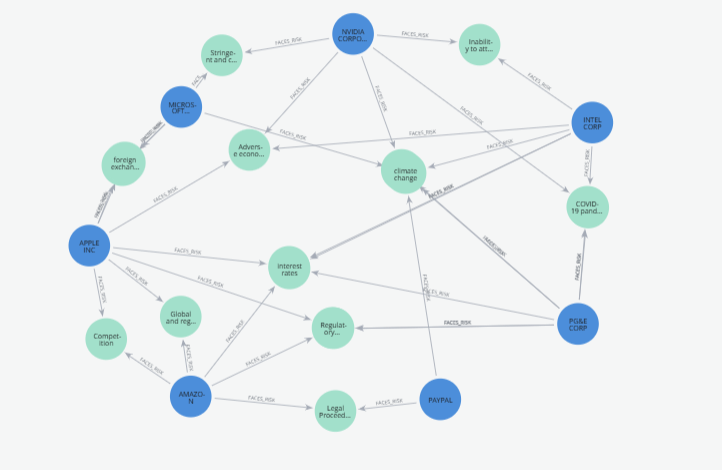

## Text2CypherRetriever Example

This section demonstrates how to use the `Text2CypherRetriever` to automatically generate Cypher queries from natural language questions.

**How it works:**
- The retriever uses a Large Language Model (LLM) to translate your plain-English query into a Cypher query, based on your Neo4j schema.
- The schema is provided as a string describing the main node types and relationships in your graph (e.g., companies, risk factors, asset managers).

**Example Workflow:**
1. You provide a natural language question, such as:
   > "What are the company names of companies owned by BlackRock Inc."
2. The retriever generates a corresponding Cypher query using the schema and the LLM.
3. The generated Cypher is printed, allowing you to inspect or execute it.

**Why this is powerful:**
- Removes the need to manually write Cypher for each question.
- Makes graph querying accessible to non-technical users.
- Great for rapid prototyping, exploration, and building natural language interfaces to your knowledge graph.



The following schema was retrieved from the connected Neo4j database using `get_schema(driver)`:


In [ ]:
schema = get_schema(driver)
print(schema)

In [ ]:
# --- Text2CypherRetriever Example ---
from requests import session

print("\n--- Text2CypherRetriever Example ---")
text2cypher_retriever = Text2CypherRetriever(
    driver=driver,
    llm=llm,
    neo4j_schema= schema
)

query = "what are the company names of companies owned by BlackRock Inc."
cypher_query = text2cypher_retriever.get_search_results(query)
print("\n--- Text2Cypher Output ---")
print("Original Query:", query)
print("Generated Cypher:\n", cypher_query.metadata["cypher"])


## Executing the Generated Cypher Query

This section runs the Cypher query generated by the `Text2CypherRetriever` and displays the results.

**How it works:**
- The Cypher query, generated from your natural language question, is executed directly against the Neo4j database using the `driver`.
- Each record returned by the query is printed for inspection.

**Why this is useful:**
- Allows you to see the actual data returned from your graph for your question, closing the loop from natural language to structured results.
- Lets you verify both the correctness of the generated Cypher and the quality of the graph data.

**Typical workflow:**
1. Use the retriever to generate Cypher from your question.
2. Execute the Cypher and review the results.
3. Iterate on your question or schema as needed to improve answers.


In [ ]:
result = driver.execute_query(cypher_query.metadata["cypher"])
for record in result.records:
    print(record)

## Next Steps & Troubleshooting

- Try different queries to explore your knowledge graph.
- If you encounter errors, check your environment variables and ensure all dependencies are installed.
- For advanced graph exploration, see the optional agent notebook (`04_Neo4j_agent_notebook.ipynb`).</p>

>
> **Need help?**  
> Refer to the project README or open an issue in the repository.